# Keras_DNN

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import seaborn as sns

import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "keras_DNN"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

import platform
from matplotlib import font_manager, rc

#매킨토시의 경우
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
#윈도우의 경우
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)

mpl.rcParams['axes.unicode_minus'] = False


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
import warnings
warnings.filterwarnings(action='ignore')


## 그레이디언트 소실과 폭주 문제

### 로지스틱 활성화 함수의 수렴

그림 저장: sigmoid_saturation_plot


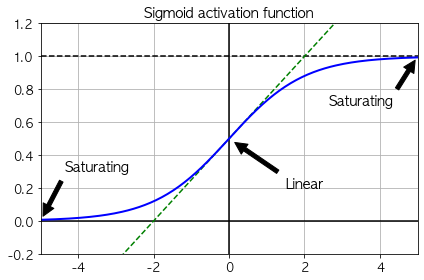

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

In [3]:
# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

### He 초기화

In [4]:
#모든 초기화 방식을 확인
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
#글로럿 초기화
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
#균등분포 He 초기화
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

### LeakyReLu

그림 저장: leaky_relu_plot


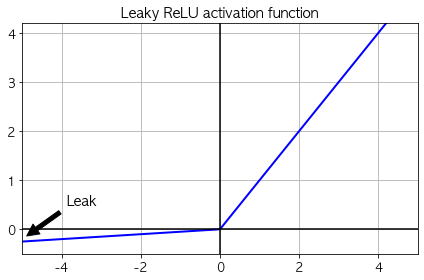

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [8]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [9]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

In [10]:
#LeakyReLU를 사용해 패션 MNIST에서 신경망을 훈련

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [11]:
#모델 생성
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [12]:
#모델 컴파일
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [13]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7955 - accuracy: 0.7362 - val_loss: 0.7130 - val_accuracy: 0.7658
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7896
Epoch 4/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5832 - accuracy: 0.8074 - val_loss: 0.5582 - val_accuracy: 0.8198
Epoch 6/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5553 - accuracy: 0.8156 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5338 - accuracy: 0.8225 - val_loss: 0.5157 - val_accuracy:

### PReLU

In [14]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [15]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [16]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8197 - accuracy: 0.7356 - val_loss: 0.7305 - val_accuracy: 0.7630
Epoch 3/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.6966 - accuracy: 0.7693 - val_loss: 0.6565 - val_accuracy: 0.7878
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6004 - val_accuracy: 0.8048
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5917 - accuracy: 0.8057 - val_loss: 0.5657 - val_accuracy: 0.8178
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5619 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5391 - accuracy: 0.8205 - val_loss: 0.5196 - val_accuracy:

### ELU

In [17]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

그림 저장: elu_plot


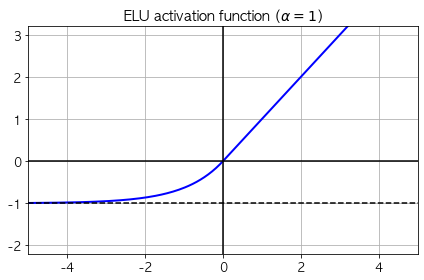

In [18]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

In [19]:
#텐서플로에서 쉽게 ELU를 적용할 수 있는데 층을 만들 때 활성화 함수로 지정
keras.layers.Dense(10, activation="elu")

### SELU

In [20]:
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화합니다
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [21]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

그림 저장: selu_plot


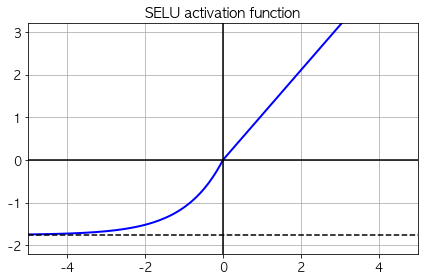

In [22]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

In [23]:
#기본적으로 SELU 하이퍼파라미터(scale과 alpha)는 각 뉴런의 평균 출력이 0에 가깝고 표준 편차는 1에 가깝도록 조정됩니다
#입력은 평균이 0이고 표준 편차 1로 표준화되었다고 가정합니다
#이 활성화 함수를 사용하면 1,000개의 층이 있는 심층 신경망도 모든 층에 걸쳐 거의 평균이 0이고 표준 편차를 1로 유지합니다. 
#이를 통해 그레이디언트 폭주와 소실 문제를 피할 수 있습니다:

np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # 표준화된 입력
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun 초기화
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [24]:
#은닉층에 적용
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

In [25]:
#SELU를 패션 MNIST에 적용
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [26]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [27]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [28]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 17s 9ms/step - loss: 1.1601 - accuracy: 0.5687 - val_loss: 0.9045 - val_accuracy: 0.6780
Epoch 2/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.7684 - accuracy: 0.7218 - val_loss: 0.6317 - val_accuracy: 0.7806
Epoch 3/5
1719/1719 [==============================] - 13s 8ms/step - loss: 0.6269 - accuracy: 0.7720 - val_loss: 0.5934 - val_accuracy: 0.7850
Epoch 4/5
1719/1719 [==============================] - 13s 8ms/step - loss: 0.5838 - accuracy: 0.7889 - val_loss: 0.5511 - val_accuracy: 0.8018
Epoch 5/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5397 - accuracy: 0.8083 - val_loss: 0.5151 - val_accuracy: 0.8160


In [29]:
#ReLU를 사용한 경우
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 15s 7ms/step - loss: 1.8177 - accuracy: 0.2524 - val_loss: 1.3441 - val_accuracy: 0.4368
Epoch 2/5
1719/1719 [==============================] - 12s 7ms/step - loss: 1.2103 - accuracy: 0.4798 - val_loss: 0.9334 - val_accuracy: 0.6366
Epoch 3/5
1719/1719 [==============================] - 12s 7ms/step - loss: 1.0028 - accuracy: 0.5883 - val_loss: 1.0177 - val_accuracy: 0.5876
Epoch 4/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.9256 - accuracy: 0.6209 - val_loss: 0.7916 - val_accuracy: 0.6838
Epoch 5/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.8485 - accuracy: 0.6611 - val_loss: 0.8464 - val_accuracy: 0.6512


### 배치 정규화

In [30]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_212 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_213 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_214 (Dense)            (None, 10)               

In [31]:
#파라미터 확인
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [32]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 0.8750 - accuracy: 0.7124 - val_loss: 0.5525 - val_accuracy: 0.8230
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5753 - accuracy: 0.8029 - val_loss: 0.4724 - val_accuracy: 0.8472
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5189 - accuracy: 0.8204 - val_loss: 0.4376 - val_accuracy: 0.8550
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4827 - accuracy: 0.8322 - val_loss: 0.4151 - val_accuracy: 0.8600
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4565 - accuracy: 0.8407 - val_loss: 0.3996 - val_accuracy: 0.8644
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4398 - accuracy: 0.8471 - val_loss: 0.3866 - val_accuracy: 0.8700
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4242 - accuracy: 0.8513 - val_loss: 0.3762 - val_accuracy:

In [33]:
#활성화 전에 BN을 적용
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [34]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 1.0317 - accuracy: 0.6757 - val_loss: 0.6767 - val_accuracy: 0.7810
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6790 - accuracy: 0.7793 - val_loss: 0.5566 - val_accuracy: 0.8180
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5960 - accuracy: 0.8039 - val_loss: 0.5007 - val_accuracy: 0.8362
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5447 - accuracy: 0.8192 - val_loss: 0.4666 - val_accuracy: 0.8450
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5109 - accuracy: 0.8278 - val_loss: 0.4434 - val_accuracy: 0.8534
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4898 - accuracy: 0.8337 - val_loss: 0.4263 - val_accuracy: 0.8546
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4712 - accuracy: 0.8395 - val_loss: 0.4130 - val_accuracy:

### 그레이디언트 클리핑

In [35]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [36]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## 사전 훈련된 층 재사용하기

### 케라스를 이용한 전이 학습

In [37]:
# 데이터 셋 분할
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [38]:
X_train_A.shape

(43986, 28, 28)

In [39]:
X_train_B.shape

(200, 28, 28)

In [40]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [41]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [42]:
tf.random.set_seed(42)
np.random.seed(42)

model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.5926 - accuracy: 0.8104 - val_loss: 0.3894 - val_accuracy: 0.8665
Epoch 2/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.3523 - accuracy: 0.8788 - val_loss: 0.3287 - val_accuracy: 0.8822
Epoch 3/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.3170 - accuracy: 0.8895 - val_loss: 0.3010 - val_accuracy: 0.8994
Epoch 4/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2973 - accuracy: 0.8976 - val_loss: 0.2894 - val_accuracy: 0.9023
Epoch 5/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2835 - accuracy: 0.9020 - val_loss: 0.2770 - val_accuracy: 0.9068
Epoch 6/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2730 - accuracy: 0.9060 - val_loss: 0.2731 - val_accuracy: 0.9068
Epoch 7/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2641 - accuracy: 0.9090 - val_loss: 0.2719 - val_accuracy:

In [43]:
model_A.save("my_model_A.h5")

In [44]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 25ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 9ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 9ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 8ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 9ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 9ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 9ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [=================

In [45]:
model_B.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_224 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_225 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_226 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_227 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_228 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_229 (Dense)            (None, 1)                

In [46]:
# 모델 B 에서 모델 A를 재사용
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 26ms/step - loss: 0.5784 - accuracy: 0.6550 - val_loss: 0.5827 - val_accuracy: 0.6308
Epoch 2/4
7/7 [==============================] - 0s 10ms/step - loss: 0.5419 - accuracy: 0.6750 - val_loss: 0.5453 - val_accuracy: 0.6775
Epoch 3/4
7/7 [==============================] - 0s 10ms/step - loss: 0.5051 - accuracy: 0.7300 - val_loss: 0.5132 - val_accuracy: 0.7110
Epoch 4/4
7/7 [==============================] - 0s 9ms/step - loss: 0.4735 - accuracy: 0.7450 - val_loss: 0.4845 - val_accuracy: 0.7373
Epoch 1/16
7/7 [==============================] - 1s 27ms/step - loss: 0.3955 - accuracy: 0.8150 - val_loss: 0.3458 - val_accuracy: 0.8641
Epoch 2/16
7/7 [==============================] - 0s 11ms/step - loss: 0.2796 - accuracy: 0.9350 - val_loss: 0.2604 - val_accuracy: 0.9280
Epoch 3/16
7/7 [==============================] - 0s 10ms/step - loss: 0.2082 - accuracy: 0.9650 - val_loss: 0.2111 - val_accuracy: 0.9554
Epoch 4/16
7/7 [================

In [47]:
# 마지막 점수
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407837152481, 0.9704999923706055]

In [48]:
#마지막 점수
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.0683 - accuracy: 0.9930


[0.06831967830657959, 0.9929999709129333]

In [49]:
(100 - 97.05) / (100 - 99.35)

4.538461538461503

## 옵티마이저

### 모멘텀 최적화

In [50]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

### 네스테로프 가속 경사

In [51]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

### AdaGrad

In [52]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

### RMSprop

In [53]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

### Adam

In [54]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

### AdaMax

In [55]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

### Nadam

In [56]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

## 학습률 스케쥴링

### 거듭 제곱 스케쥴링

In [57]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4855 - accuracy: 0.8304 - val_loss: 0.4029 - val_accuracy: 0.8592
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3782 - accuracy: 0.8657 - val_loss: 0.3717 - val_accuracy: 0.8732
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3459 - accuracy: 0.8770 - val_loss: 0.3752 - val_accuracy: 0.8744
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3251 - accuracy: 0.8829 - val_loss: 0.3503 - val_accuracy: 0.8794
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3102 - accuracy: 0.8891 - val_loss: 0.3449 - val_accuracy: 0.8784
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2967 - accuracy: 0.8935 - val_loss: 0.3416 - val_accuracy: 0.8828
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2868 - accuracy: 0.8972 - val_loss: 0.3360 - val_accuracy:

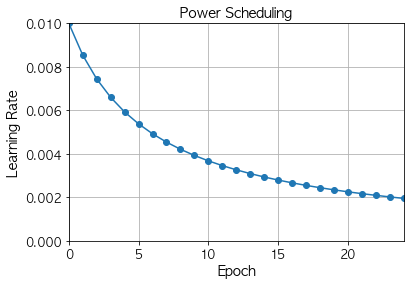

In [58]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 지수 기반 스케쥴링

In [59]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8387 - accuracy: 0.7577 - val_loss: 0.8019 - val_accuracy: 0.7724
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6573 - accuracy: 0.7995 - val_loss: 0.5552 - val_accuracy: 0.8170
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6019 - accuracy: 0.8113 - val_loss: 0.5884 - val_accuracy: 0.8312
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5423 - accuracy: 0.8331 - val_loss: 0.4945 - val_accuracy: 0.8470
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4915 - accuracy: 0.8454 - val_loss: 0.4834 - val_accuracy: 0.8518
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4381 - accuracy: 0.8596 - val_loss: 0.6682 - val_accuracy: 0.8538
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4106 - accuracy: 0.8680 - val_loss: 0.5475 - val_accuracy:

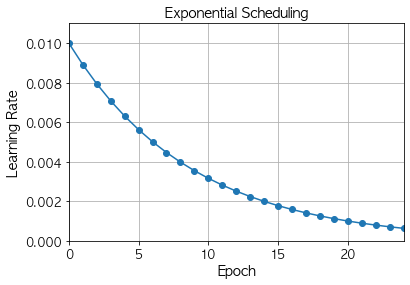

In [60]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 에포크가 아니라 반복마다 학습률을 업데이트하려면 사용자 정의 콜백 클래스를 작성해야 함

In [61]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # 노트: 에포크마다 `batch` 매개변수가 재설정됩니다
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # 20 에포크 동안 스텝 횟수 (배치 크기 = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8247 - accuracy: 0.7599 - val_loss: 0.8553 - val_accuracy: 0.7546
Epoch 2/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6278 - accuracy: 0.8072 - val_loss: 0.5424 - val_accuracy: 0.8280
Epoch 3/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5635 - accuracy: 0.8251 - val_loss: 0.7209 - val_accuracy: 0.7670
Epoch 4/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5048 - accuracy: 0.8419 - val_loss: 0.5432 - val_accuracy: 0.8472
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4742 - accuracy: 0.8516 - val_loss: 0.4731 - val_accuracy: 0.8632
Epoch 6/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4214 - accuracy: 0.8659 - val_loss: 0.4793 - val_accuracy: 0.8574
Epoch 7/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3945 - accuracy: 0.8743 - val_loss: 0.4927 - val_accuracy:

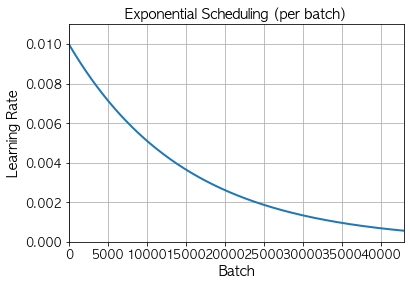

In [62]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

## 규제를 사용해 과대적합 피하기

### $\ell_1$과 $\ell_2$ 규제

In [63]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [64]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 1.6253 - accuracy: 0.8116 - val_loss: 0.7192 - val_accuracy: 0.8300
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7189 - accuracy: 0.8274 - val_loss: 0.6832 - val_accuracy: 0.8364


### 가독성 높이기

In [65]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 1.6192 - accuracy: 0.8112 - val_loss: 0.7174 - val_accuracy: 0.8326
Epoch 2/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7200 - accuracy: 0.8269 - val_loss: 0.6815 - val_accuracy: 0.8390


### 드롭아웃

In [66]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5676 - accuracy: 0.8032 - val_loss: 0.3677 - val_accuracy: 0.8672
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4191 - accuracy: 0.8455 - val_loss: 0.3488 - val_accuracy: 0.8722


### 알파 드롭아웃

In [67]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))



Epoch 1/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6640 - accuracy: 0.7593 - val_loss: 0.5783 - val_accuracy: 0.8444
Epoch 2/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5566 - accuracy: 0.7944 - val_loss: 0.5195 - val_accuracy: 0.8520
Epoch 3/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5205 - accuracy: 0.8079 - val_loss: 0.4911 - val_accuracy: 0.8598
Epoch 4/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5085 - accuracy: 0.8119 - val_loss: 0.4806 - val_accuracy: 0.8582
Epoch 5/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4952 - accuracy: 0.8180 - val_loss: 0.4225 - val_accuracy: 0.8692
Epoch 6/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4828 - accuracy: 0.8201 - val_loss: 0.4587 - val_accuracy: 0.8628
Epoch 7/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4727 - accuracy: 0.8234 - val_loss: 0.4732 - val_accuracy:

In [68]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 0s 879us/step - loss: 0.4789 - accuracy: 0.8570


[0.47888627648353577, 0.8569999933242798]

In [69]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 1s 766us/step - loss: 0.3545 - accuracy: 0.8811


[0.354548841714859, 0.8811091184616089]

In [70]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 4s 2ms/step - loss: 0.4222 - accuracy: 0.8437


### 몬테카를로 드롭아웃

In [73]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)
    
tf.random.set_seed(42)
np.random.seed(42)

mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

mc_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout (MCAlphaDro (None, 784)               0         
_________________________________________________________________
dense_250 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_1 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_251 (Dense)            (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_2 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_252 (Dense)            (None, 10)              

In [76]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

mc_model.set_weights(model.get_weights())

In [77]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.25, 0.  , 0.63]],
      dtype=float32)

### 맥스-노름 규제

In [78]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 7s 3ms/step - loss: 0.4748 - accuracy: 0.8323 - val_loss: 0.3633 - val_accuracy: 0.8656
Epoch 2/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3540 - accuracy: 0.8719 - val_loss: 0.3674 - val_accuracy: 0.8690
